## Imports

In [1]:
import pantab
from tableauhyperapi import TableName
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import jit
import ruptures as rpt
from ruptures import display
from sklearn.linear_model import LinearRegression
import missingno as msno
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from tabpy.tabpy_tools.client import Client
import logging

%load_ext lab_black

FS = (16, 9)

In [2]:
import matplotlib as mpl

mpl.rcParams.update({"legend.fontsize": 18})
mpl.rcParams.update({"xtick.labelsize": 20})
mpl.rcParams.update({"xtick.color": "dimgrey"})
mpl.rcParams.update({"ytick.labelsize": 20})
mpl.rcParams.update({"ytick.color": "dimgrey"})
mpl.rcParams.update({"axes.labelsize": 22})
mpl.rcParams.update({"axes.labelcolor": "dimgrey"})
mpl.rcParams.update({"axes.titlesize": 28})
mpl.rcParams.update({"axes.edgecolor": "dimgrey"})
mpl.rcParams.update({"font.family": "sans-serif"})
mpl.rcParams.update({"font.sans-serif": "Arial"})
mpl.rcParams.update({"legend.frameon": False})
mpl.rcParams.update({"legend.fancybox": False})
mpl.rcParams.update({"legend.shadow": False})
mpl.rcParams.update({"legend.facecolor": "w"})
mpl.rcParams.update({"legend.framealpha": 0.8})
mpl.rcParams.update({"grid.color": "dimgrey"})
mpl.rcParams.update({"grid.alpha": 0.5})
mpl.rcParams.update({"text.color": "grey"})
mpl.rcParams.update({"lines.linewidth": 2})
mpl.rcParams.update({"legend.title_fontsize": 20})

## Functions to detect outlying trends 

In [3]:
# modified Z-score based method, implemented with Numba


@jit(nopython=True)
def compute_mad_lo(x, threshold):
    x_tilde = np.median(x)
    mad = np.median(np.fabs(x - x_tilde))
    return x_tilde - 1.4825796886582654 * threshold * mad  # 1.0 / 0.6745


@jit(nopython=True)
def compute_mad_up(x, threshold):
    x_tilde = np.median(x)
    mad = np.median(np.fabs(x - x_tilde))
    return x_tilde + 1.4825796886582654 * threshold * mad  # 1.0 / 0.6745


def detect_outliers(ts, window_size=30, threshold=3.5):
    if not isinstance(ts, pd.core.series.Series):
        raise TypeError("ts must be a Pandas Series")
    if not isinstance(ts.index, pd.DatetimeIndex):
        raise TypeError("ts must have a DatetimeIndex")
    if ts.index.freq == "D":
        freq_str = "D"
    else:
        raise ValueError("Wrong time series frequency")
    window_str = str(window_size) + freq_str
    df = ts.to_frame("val")
    df["mad_lo"] = (
        df.val.dropna()
        .rolling(window_str)
        .apply(compute_mad_lo, args=(threshold,), raw=True)
    )
    df["mad_up"] = (
        df.val.dropna()
        .rolling(window_str)
        .apply(compute_mad_up, args=(threshold,), raw=True)
    )
    df["outlier"] = False
    df.loc[(df.val < df.mad_lo) | (df.val > df.mad_up), "outlier"] = True
    return df.outlier

In [4]:
def detect_change_points(signal, model="rbf", min_size=5, jump=5, pen=10):
    algo = rpt.Pelt(model=model, min_size=min_size, jump=jump).fit(signal)
    bkps = algo.predict(pen=pen)
    return bkps

In [5]:
def extract_features(ts_in, plot=True):
    ts = ts_in.copy(deep=True)
    outliers = detect_outliers(ts)
    ts.loc[outliers] = np.NaN
    signal = ts.dropna().values
    name = ts.name
    bkps = detect_change_points(signal)

    df = ts.dropna().to_frame()
    df["segment"] = 0
    df.loc[df.iloc[bkps[:-1]].index, "segment"] = 1
    df.segment = df.segment.cumsum()

    slopes = []
    seg_lengths = []
    df["piecelin"] = 0.0
    df["slope"] = 0.0
    for i in df.segment.unique():
        seg = df.loc[df.segment == i].asfreq("D")[name].reset_index(drop=True).dropna()
        y = seg.values
        X = seg.index.values.reshape(-1, 1)
        model = make_pipeline(
            StandardScaler(with_mean=False), LinearRegression(fit_intercept=True)
        )
        reg = model.fit(X, y)
        df.loc[(df.segment == i) & ~df[name].isna(), "piecelin"] = reg.predict(X)
        df.loc[(df.segment == i) & ~df[name].isna(), "slope"] = reg[
            "linearregression"
        ].coef_[0]

    outliers = detect_outliers(ts)
    if plot:
        ax = ts.plot(figsize=FS, style=".", c="#F1D05E", ms=15, alpha=0.75, grid=True)
        _ = df.piecelin.plot(ax=ax, c="#325160", grid=True)
        _ = ax.set_ylim(
            0,
        )
        _ = ax.set(
            xlabel="Date",
            title=str(name) + " with piecewise linear approx.",
            ylabel="Elapsed time (s)",
        )

    return df

## Code for Tabpy

In [6]:
def prepare_data(data, index):
    # format index to have a datatime index
    t1 = pd.to_datetime(index)
    t2 = t1.to_frame()[0].dt.date.values
    index_date = pd.to_datetime(t2)

    # create the dataframe
    df = pd.DataFrame(data, index=index_date)
    df_notnull = df[pd.notnull(df.index)]

    # resample et tranform to serie
    df_notnull = df_notnull.resample("D").mean()
    ts = df_notnull.squeeze()
    return ts, df

In [7]:
def error(message, value, length):
    error_list = []
    logger = logging.getLogger(__name__)
    logger.error(message)
    for _ in range(length):
        error_list.append(value)
    return error_list

In [8]:
def detect_outliers_list(data, index):
    ts, df1 = prepare_data(data, index)

    if not isinstance(ts, pd.core.series.Series):
        return error("Wrong format, ts must be a Pandas Series", True, len(data))
    if not isinstance(ts.index, pd.DatetimeIndex):
        return error("Index must be of type : DatetimeIndex ", True, len(data))
    if ts.index.freq != "D":
        return error("Wrong frequency (Day frequence needed)", True, len(data))

    outliers = detect_outliers(ts)
    concat = pd.merge(df1, outliers, left_index=True, right_index=True, how="left")
    return concat["outlier"].values.tolist()

In [9]:
def extract_feature_list(data, index, element):
    ts, df1 = prepare_data(data, index)

    if not isinstance(ts, pd.core.series.Series):
        return error("Wrong format, ts must be a Pandas Series", 0, len(data))
    if not isinstance(ts.index, pd.DatetimeIndex):
        return error("Index must be of type : DatetimeIndex ", 0, len(data))
    if ts.index.freq != "D":
        return error("Wrong frequency (Day frequence needed)", 0, len(data))

    res = extract_features(ts, True)
    concat = pd.merge(df1, res, left_index=True, right_index=True, how="left")
    return concat[element].values.tolist()

In [10]:
def get_segment(data, index):
    return extract_feature_list(data, index, "segment")


def get_approximation(data, index):
    return extract_feature_list(data, index, "piecelin")


def get_slope(data, index):
    return extract_feature_list(data, index, "slope")

In [11]:
from tabpy.tabpy_tools.client import Client

connection = Client("http://localhost:9004/")
connection.deploy(
    "detect_outliers_list",
    detect_outliers_list,
    "return true if outlier",
    override=True,
)
connection.deploy(
    "get_segment", get_segment, "return which segment it belongs to", override=True
)
connection.deploy(
    "get_approximation",
    get_approximation,
    "return piecewise approximation",
    override=True,
)
connection.deploy(
    "get_slope", get_slope, "return slope of the piecewise approximation", override=True
)

## Test with the data from hyper

In [3]:
HYPER_PATH = "ADM_CHARGEMENT_HISTO.hyper"

MIN_LENGTH_RATIO = 0.8  # 1.0 complete, 0.0 empty
MIN_VAL = 30  # values below MIN_VAL are removed

df = pantab.frame_from_hyper(HYPER_PATH, table=TableName("Extract", "Extract"))
df.drop_duplicates(keep="first", inplace=True)
df = df.loc[df.CD_RETOUR == "SUCCES"]  # only keep tasks that succeeded

df["ET"] = (
    df.DT_FIN_EXEC - df.DT_DEB_DONNEES
).dt.total_seconds()  # compute the elapsed time in seconds

# set the index
df["start"] = df.DT_DEB_DONNEES

df.set_index("start", inplace=True, drop=True)

# pivot, resample the time series
CD_JOBS = []
traces = pd.DataFrame()
for CD_JOB in sorted(df.CD_JOB.unique()):
    s = df.loc[df.CD_JOB == CD_JOB].ET.copy(deep=True)
    s = s[s > 0.0]
    s = s.resample("D").mean()
    traces = pd.concat([traces, s.to_frame(CD_JOB)], axis=1)
traces.sort_index(ascending=True, inplace=True)
traces[traces < MIN_VAL] = np.NaN  # remove very small values

# remove columns with too many NaN values
length = len(traces)
nan_count = traces.isna().sum(axis=0)
cols = sorted(nan_count[nan_count < (1.0 - MIN_LENGTH_RATIO) * length].index.values)
traces = traces[cols]


# rename the columns, due to confidentiality reasons
traces.columns = sorted(traces.columns)
traces.columns = ["c_" + str(i).zfill(2) for i in range(len(traces.columns))]

In [4]:
traces.tail(2)

,c_00,c_01,c_02,c_03,c_04,c_05,c_06,c_07,c_08,c_09,...,c_44,c_45,c_46,c_47,c_48,c_49,c_50,c_51,c_52,c_53
start,,,,,,,,,,,,,,,,,,,,,
2019-06-05,314.0,231.0,322.0,237.0,305.0,4460.0,321.0,826.0,9286.0,854.0,...,5329.0,2092.0,481.0,599.0,184.0,779.0,377.0,2062.0,1631.0,75.0
2019-06-06,311.0,239.0,170.0,376.0,323.0,4948.0,321.0,929.0,9104.0,856.0,...,5737.0,2461.0,562.0,590.0,170.0,793.0,362.0,2157.0,1387.0,74.0


In [5]:
print(f"start: {traces.index.min().date()}, end: {traces.index.max().date()}")

start: 2015-10-05, end: 2019-06-06


In [6]:
def plot_ts(col, logy=False, figsize=FS):
    ax = col.plot(style=".", figsize=figsize, grid=True, legend=False, logy=logy)
    _ = ax.set(title=col.name, xlabel="Date", ylabel="Elapsed time (s)")
    ax.autoscale(enable=True, axis="x", tight=True)

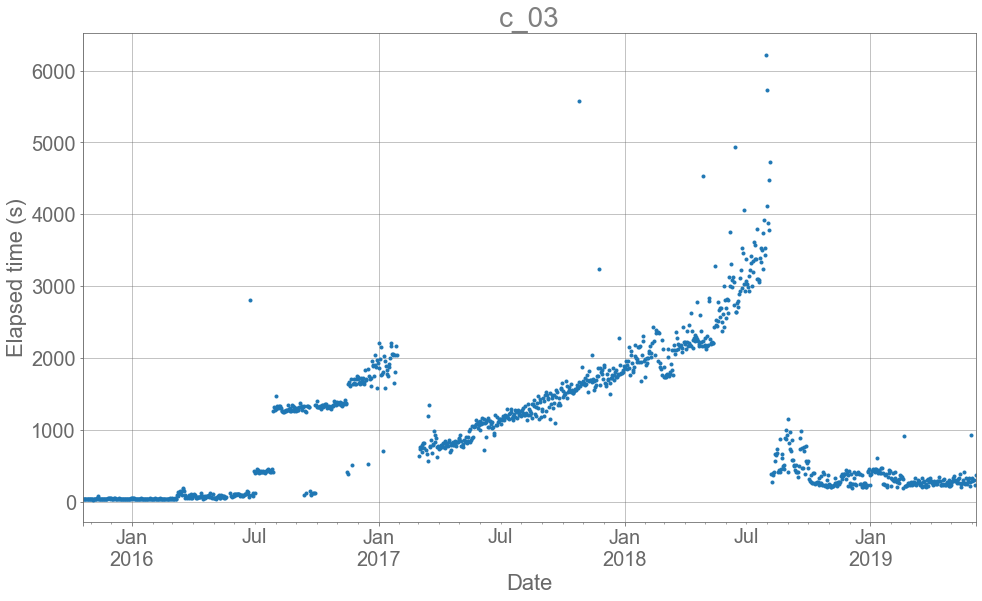

In [7]:
col3 = traces.iloc[:, 3]
plot_ts(col3)

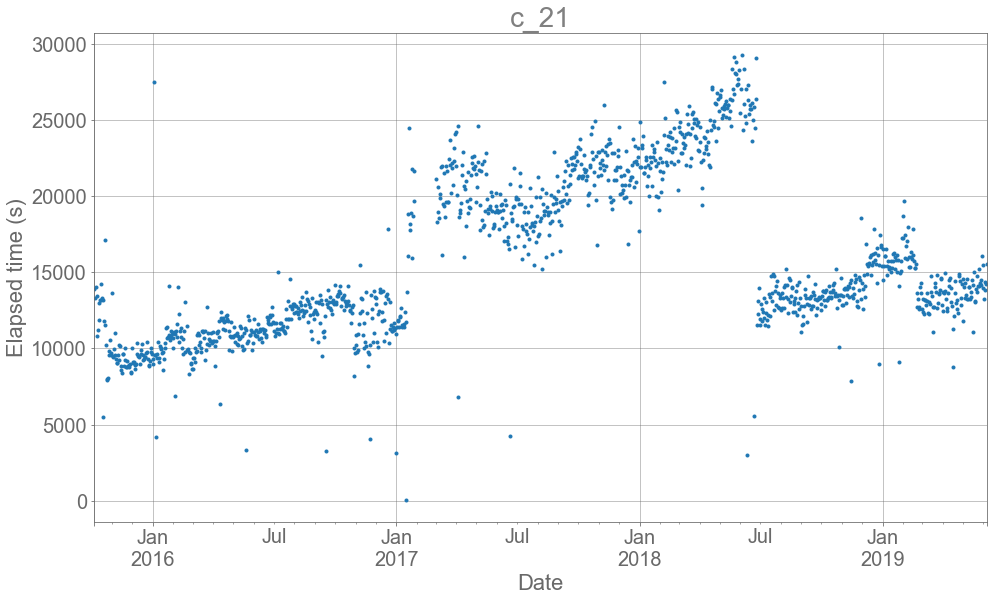

In [8]:
col21 = traces.iloc[:, 21]
plot_ts(col21)

In [10]:
def plot_outliers(ts, outliers, figsize=FS):
    if len(ts.loc[outliers] > 1):
        ax = ts.loc[outliers].plot(
            figsize=figsize, style="o", c="#F3CAA7", ms=15, alpha=0.75, grid=True
        )
        ax = ts.plot(ax=ax, style=".", c="#325160", ms=5, alpha=0.75, grid=True)
        ax.autoscale(enable=True, axis="x", tight=True)
        _ = ax.set_ylim(
            0,
        )
        ax.set(
            title=ts.name + " with outliers", xlabel="Date", ylabel="Elapsed time (s)"
        )

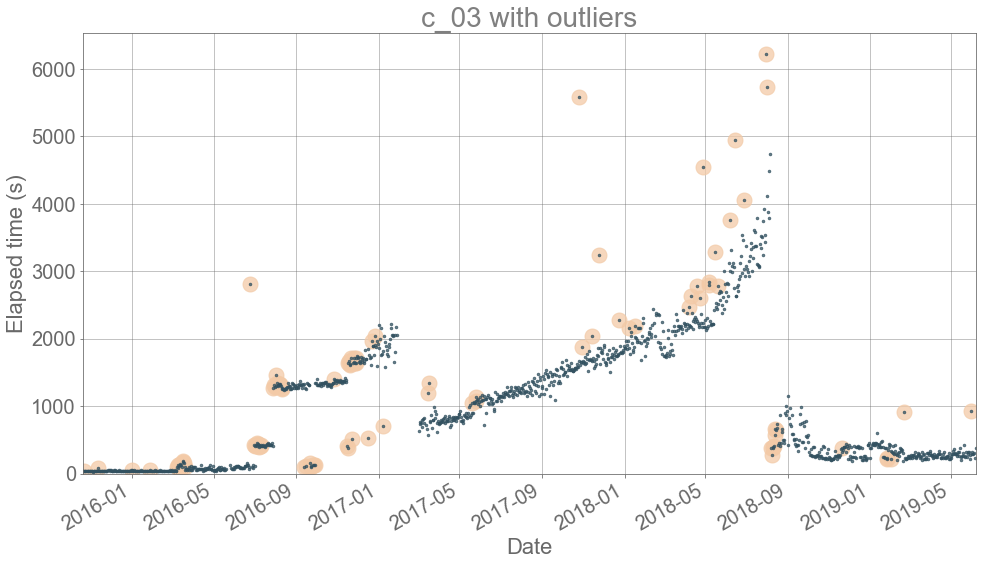

In [11]:
outliers = detect_outliers(col3)
plot_outliers(col3, outliers)

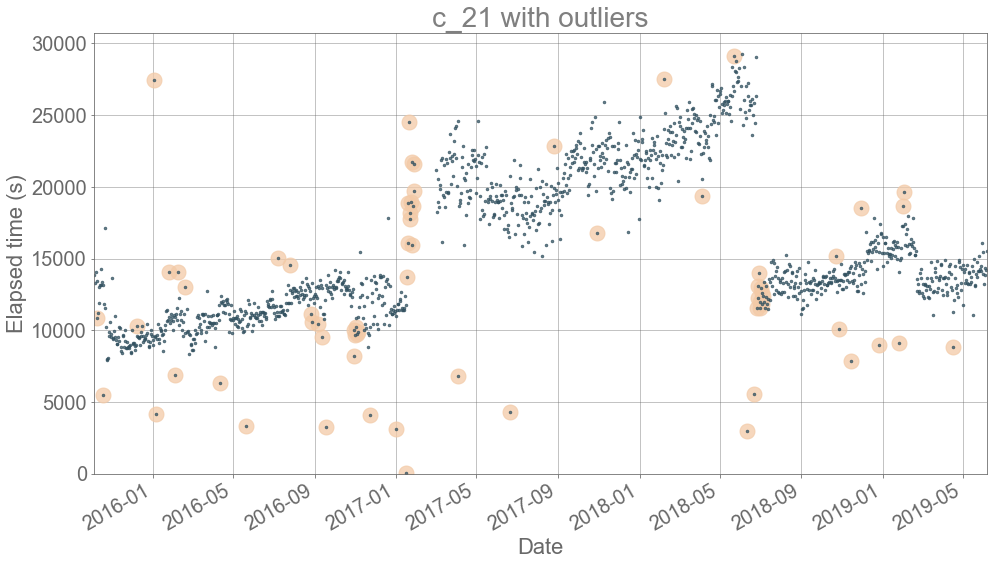

In [12]:
outliers = detect_outliers(col21)
plot_outliers(col21, outliers)

In [13]:
outliers = detect_outliers(col3)
col3.loc[outliers] = np.NaN

outliers = detect_outliers(col21)
col21.loc[outliers] = np.NaN

In [15]:
from itertools import cycle
from ruptures.utils import pairwise

COLOR_CYCLE = ["#F1D05E", "#FCF0C2"]


def display(signal, true_chg_pts, computed_chg_pts=None, figsize=(10, 6)):
    """
    Display a signal and the change points provided in alternating colors. If another set of change
    point is provided, they are displayed with dashed vertical dashed lines.
    """

    if type(signal) != np.ndarray:
        # Try to get array from Pandas dataframe
        signal = signal.values

    if signal.ndim == 1:
        signal = signal.reshape(-1, 1)
    n_samples, n_features = signal.shape

    # create plots
    fig, axarr = plt.subplots(n_features, sharex=True, figsize=figsize)
    if n_features == 1:
        axarr = [axarr]

    for axe, sig in zip(axarr, signal.T):
        color_cycle = cycle(COLOR_CYCLE)
        # plot s
        axe.scatter(range(n_samples), sig, color="#325160", s=10, alpha=0.9)

        # color each (true) regime
        bkps = [0] + sorted(true_chg_pts)
        alpha = 0.5  # transparency of the colored background

        for (start, end), col in zip(pairwise(bkps), color_cycle):
            axe.axvspan(max(0, start - 0.5), end - 0.5, facecolor=col, alpha=alpha)

        color = "k"  # color of the lines indicating the computed_chg_pts
        linewidth = 3  # linewidth of the lines indicating the computed_chg_pts
        linestyle = "--"  # linestyle of the lines indicating the computed_chg_pts
        # vertical lines to mark the computed_chg_pts
        if computed_chg_pts is not None:
            for bkp in computed_chg_pts:
                if bkp != 0 and bkp < n_samples:
                    axe.axvline(
                        x=bkp - 0.5,
                        color=color,
                        linewidth=linewidth,
                        linestyle=linestyle,
                    )

    fig.tight_layout()
    plt.grid()

    return fig, axarr

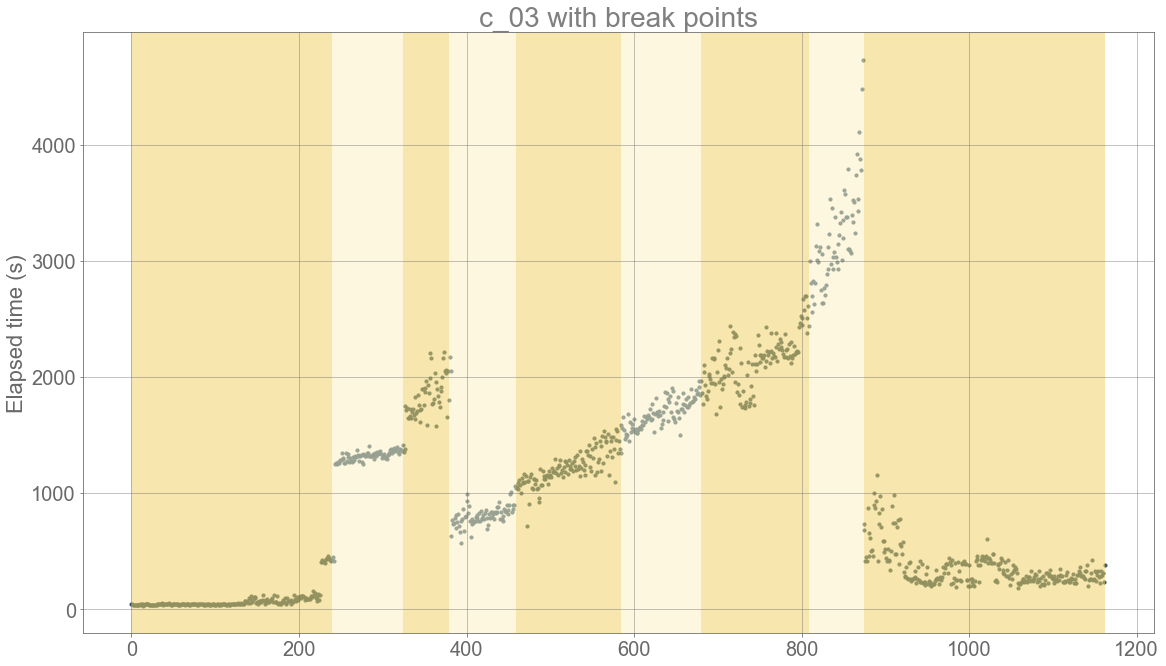

In [16]:
signal = col3.dropna().values

bkps = detect_change_points(signal)
fig, axarr = display(signal, bkps, figsize=FS)
_ = plt.title(col3.name + " with break points")
_ = plt.ylabel("Elapsed time (s)")

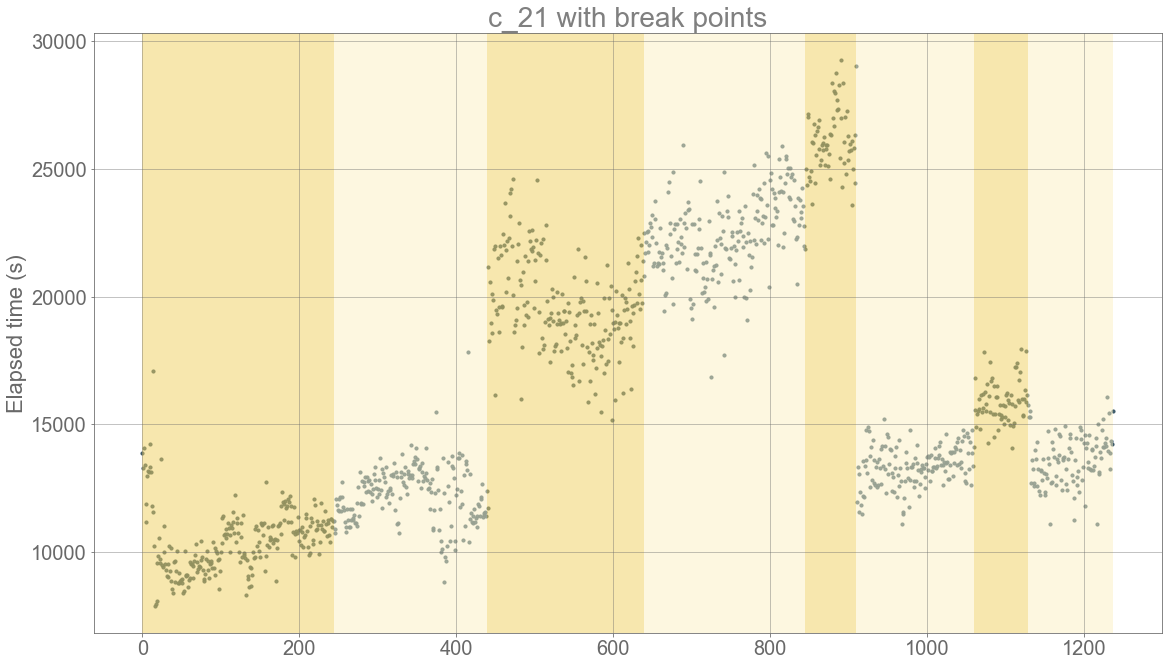

In [17]:
signal = col21.dropna().values
bkps = detect_change_points(signal)
display(signal, bkps, figsize=FS)
_ = plt.title(col21.name + " with break points")
_ = plt.ylabel("Elapsed time (s)")

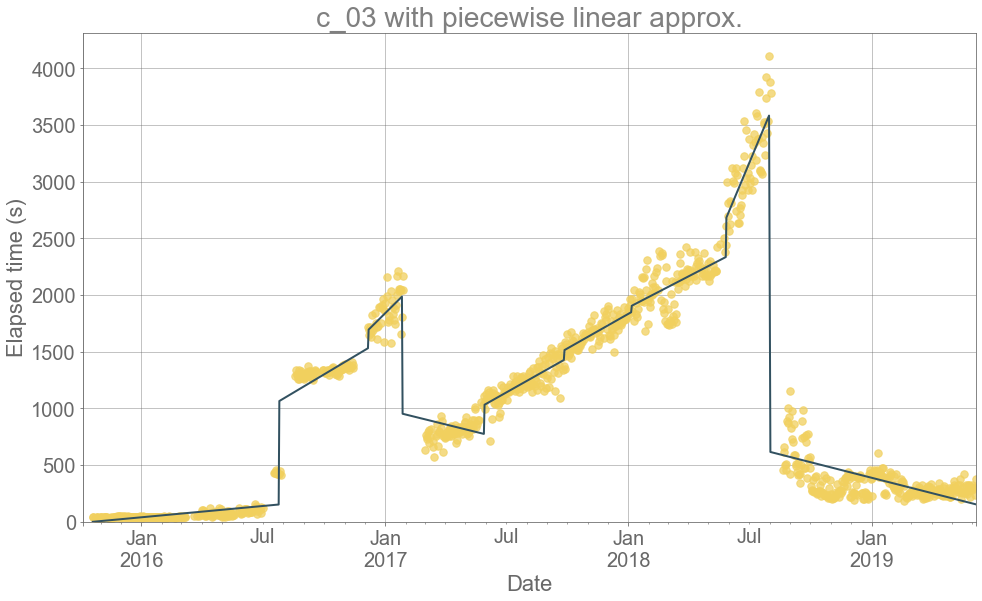

In [19]:
_ = extract_features(col3)

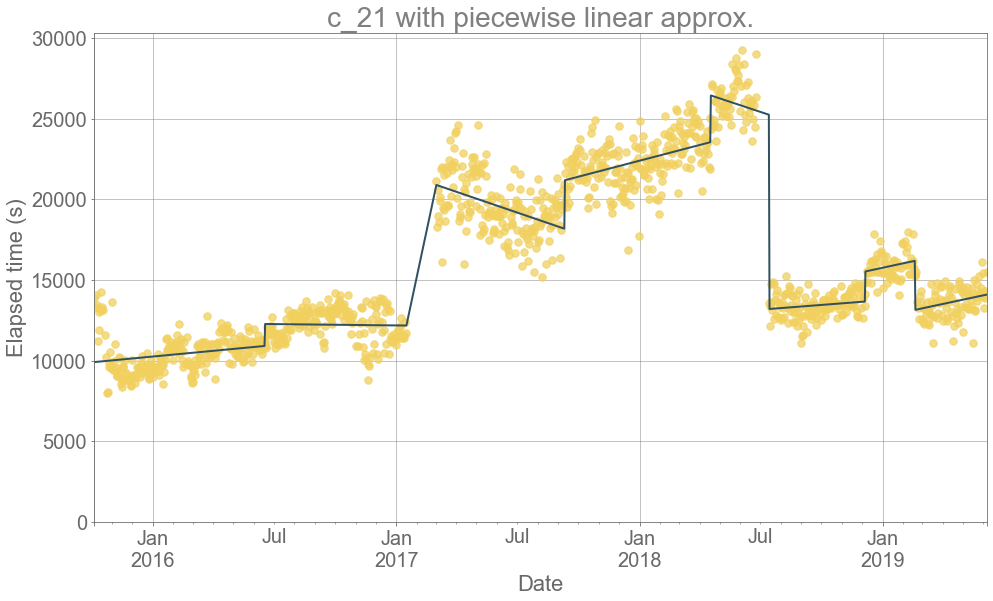

In [20]:
_ = extract_features(col21)

In [21]:
def weighted_average(y):
    l = len(y)
    alph = np.ones(l, dtype=float)
    for i in range(1, l):
        alph[i] = 1.2 * alph[i - 1]
    alph /= np.sum(alph)
    return np.dot(y, alph)


def compute_slope_coefs(ts, n_days=180):
    slope_coefs = []
    df = extract_features(ts, plot=False)
    months = df[-n_days:].slope.resample("M").mean()
    coef = weighted_average(months.values)
    return coef


# compute_slope_coefs(col21)